## Modeling Arrival Rate by Time of Day

- Why?
- We observe in the data visualization that passenger arrival rates are not constant throughout the day, so it would be more appropriate to model the arrival rate according to the hour of the day.


In [21]:
from utils import *

import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 7]


## Data Preparation

In [22]:
# load data
df_jfk = collect_data(["jfk/jfk_2022.csv", "jfk/jfk_2023.csv"])
df_jfk.head()

,FlightDate,HourRange,TotalPassengerCount,AverageWait,BoothsUsed,FlightCount,Hour,WeekDay,Month,time_of_day
0,2022-01-01,0500 - 0600,86,36,10,1,5,Saturday,January,night
1,2022-01-01,0600 - 0700,489,14,17,2,6,Saturday,January,morning
2,2022-01-01,0700 - 0800,803,19,16,4,7,Saturday,January,morning
3,2022-01-01,0800 - 0900,309,27,12,1,8,Saturday,January,morning
4,2022-01-01,1100 - 1200,189,17,10,1,11,Saturday,January,morning


In [23]:
# transform FlightDate to datetime
df_jfk['FlightDate'] = pd.to_datetime(df_jfk['FlightDate'])

# convert HourRange to Hour
df_jfk['Hour'] = df_jfk['HourRange'].str.split('-').str[0].str.strip()
df_jfk['Hour'] = (df_jfk['Hour'].astype(int)/100).astype(int)

# WeekDay column
df_jfk['WeekDay'] = df_jfk['FlightDate'].dt.day_name()

# Month column
df_jfk['Month'] = df_jfk['FlightDate'].dt.month_name()

In [24]:
# Create a new column 'time_of_day' that maps the time of the day to 'morning' or 'afternoon'

def map_time_to_period(hour):
    """
    Maps a given time range to 'morning' or 'afternoon'.
    
    Parameters:
        hour_range (str): A time range in the format "HHMM - HHMM".
    
    Returns:
        str: "morning" or "afternoon" based on the range.
    """
    # Extract the start hour from the range
    start_hour = hour
    # Map time to period
    if 6 <= start_hour < 12:
        return "morning"
    elif 12 <= start_hour < 18:
        return "afternoon"
    elif 18 <= start_hour < 24:
        return "evening"
    else:
        return "night"

df_jfk["time_of_day"] = list(map(lambda x: map_time_to_period(x), df_jfk['Hour']))

df_jfk.head()


,FlightDate,HourRange,TotalPassengerCount,AverageWait,BoothsUsed,FlightCount,Hour,WeekDay,Month,time_of_day
0,2022-01-01,0500 - 0600,86,36,10,1,5,Saturday,January,night
1,2022-01-01,0600 - 0700,489,14,17,2,6,Saturday,January,morning
2,2022-01-01,0700 - 0800,803,19,16,4,7,Saturday,January,morning
3,2022-01-01,0800 - 0900,309,27,12,1,8,Saturday,January,morning
4,2022-01-01,1100 - 1200,189,17,10,1,11,Saturday,January,morning


In [25]:
df_jfk.describe()

,FlightDate,TotalPassengerCount,AverageWait,BoothsUsed,FlightCount,Hour
count,11047,11047.000000,11047.000000,11047.000000,11047.000000,11047.000000
mean,2023-01-16 18:00:21.508101888,480.774418,24.644609,13.823934,2.230560,14.008419
min,2022-01-01 00:00:00,6.000000,0.000000,1.000000,1.000000,0.000000
25%,2022-07-24 00:00:00,257.000000,15.000000,11.000000,1.000000,9.000000
50%,2023-01-24 00:00:00,425.000000,21.000000,14.000000,2.000000,14.000000
75%,2023-07-15 00:00:00,658.000000,31.000000,17.000000,3.000000,19.000000
max,2023-12-31 00:00:00,1934.000000,120.000000,27.000000,8.000000,23.000000
std,NaN,292.776922,13.800408,4.092898,1.214455,5.469735


## Data Exploration

### Wait time along the year

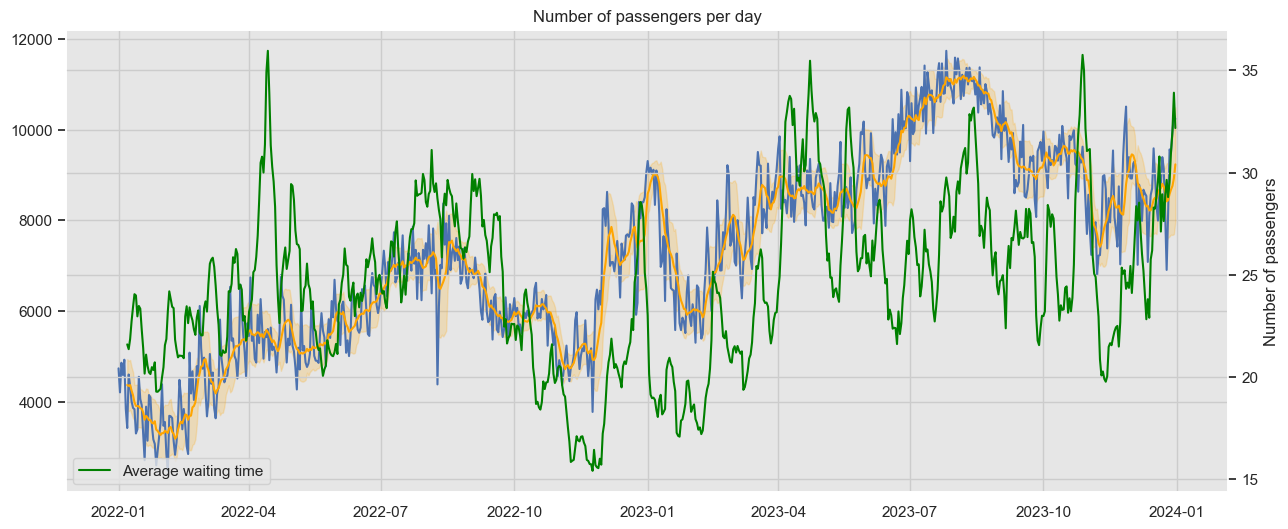

In [26]:
# Series of the number of passengers per day
passengers_per_day = df_jfk.groupby('FlightDate')['TotalPassengerCount'].sum()
# weekly rolling mean
passengers_per_day_rolling_mean = passengers_per_day.rolling(window=7).mean()
passengers_per_day_rolling_std = passengers_per_day.rolling(window=7).std()

# plot the number of passengers per day and its bollinger bands in a rolling window of 7 days
plt.figure(figsize=(15, 6))
plt.plot(passengers_per_day, label='Passengers per day')
plt.plot(passengers_per_day_rolling_mean, label='Rolling mean', color='orange')
plt.fill_between(passengers_per_day.index, passengers_per_day_rolling_mean - passengers_per_day_rolling_std, passengers_per_day_rolling_mean + passengers_per_day_rolling_std, color='orange', alpha=0.2)

# Includ in a second y-axis the average waiting time per day
plt.twinx()
passengers_wait_time = df_jfk.groupby('FlightDate')['AverageWait'].mean()
passengers_wait_time_rolling_mean = passengers_wait_time.rolling(window=7).mean()
plt.plot(passengers_wait_time_rolling_mean, label='Average waiting time', color='green')

# Add labels and legend
plt.xlabel('Date')

plt.title('Number of passengers per day')
plt.ylabel('Number of passengers')
plt.legend()


### How waiting times varies along the year and the day of the week?

In [27]:
# Dictionary for the order of the week days
week_day_order = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
# Dictionary for the order of the months
month_order = {'January': 0, 'February': 1, 'March': 2, 'April': 3, 'May': 4, 'June': 5, 'July': 6, 'August': 7, 'September': 8, 'October': 9, 'November': 10, 'December': 11}

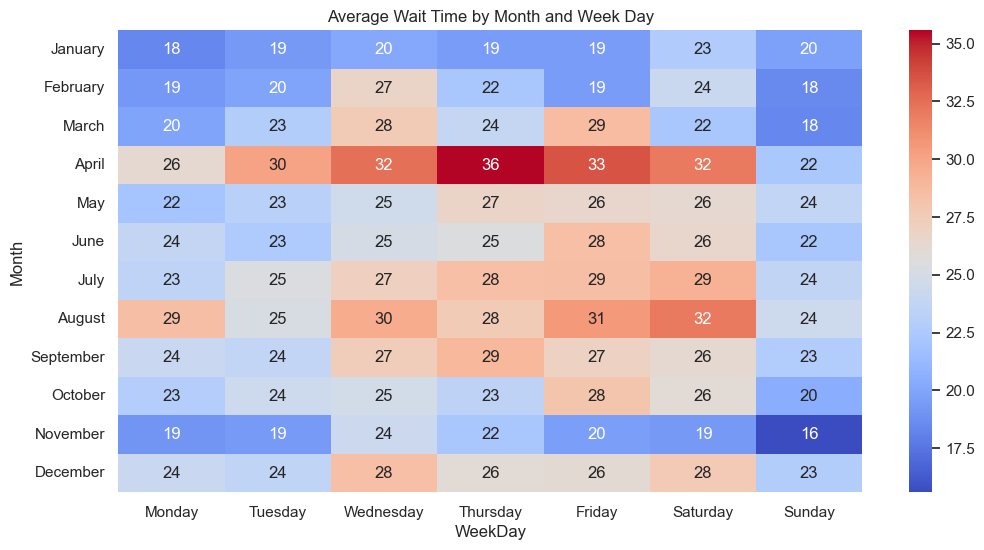

In [28]:
# Average of wait time by month and week day
df_month_day = df_jfk.groupby(['Month', 'WeekDay'])['AverageWait'].mean()

# Heatmap of the average wait time by month and week day
df_month_day = df_month_day.reset_index()
df_month_day = df_month_day.pivot(index='Month', columns='WeekDay', values='AverageWait')

# Apply the order to the columns and index
df_month_day = df_month_day[[day for day in week_day_order.keys()]]
df_month_day = df_month_day.loc[[month for month in month_order.keys()]]
# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_month_day, annot=True, fmt=".0f", cmap='coolwarm')
plt.title('Average Wait Time by Month and Week Day')
plt.show()

### How waiting times varies during the week and time?

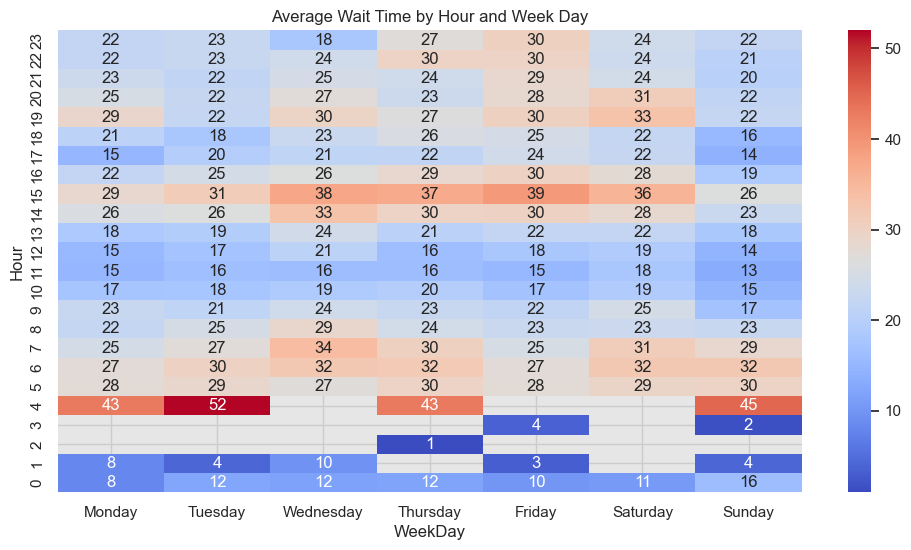

In [29]:
# Average of wait time by hour and week day
df_hour_day = df_jfk.groupby(['Hour', 'WeekDay'])['AverageWait'].mean()
# Heatmap of the average wait time by hour and week day
df_hour_day = df_hour_day.reset_index()
df_hour_day = df_hour_day.pivot(index='Hour', columns='WeekDay', values='AverageWait')
# Apply the order to the columns
df_hour_day = df_hour_day[[day for day in week_day_order.keys()]]
# Reverse the order of the hours
df_hour_day = df_hour_day.loc[df_hour_day.index[::-1]]
# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_hour_day, annot=True, fmt=".0f", cmap='coolwarm')
plt.title('Average Wait Time by Hour and Week Day')
plt.show()

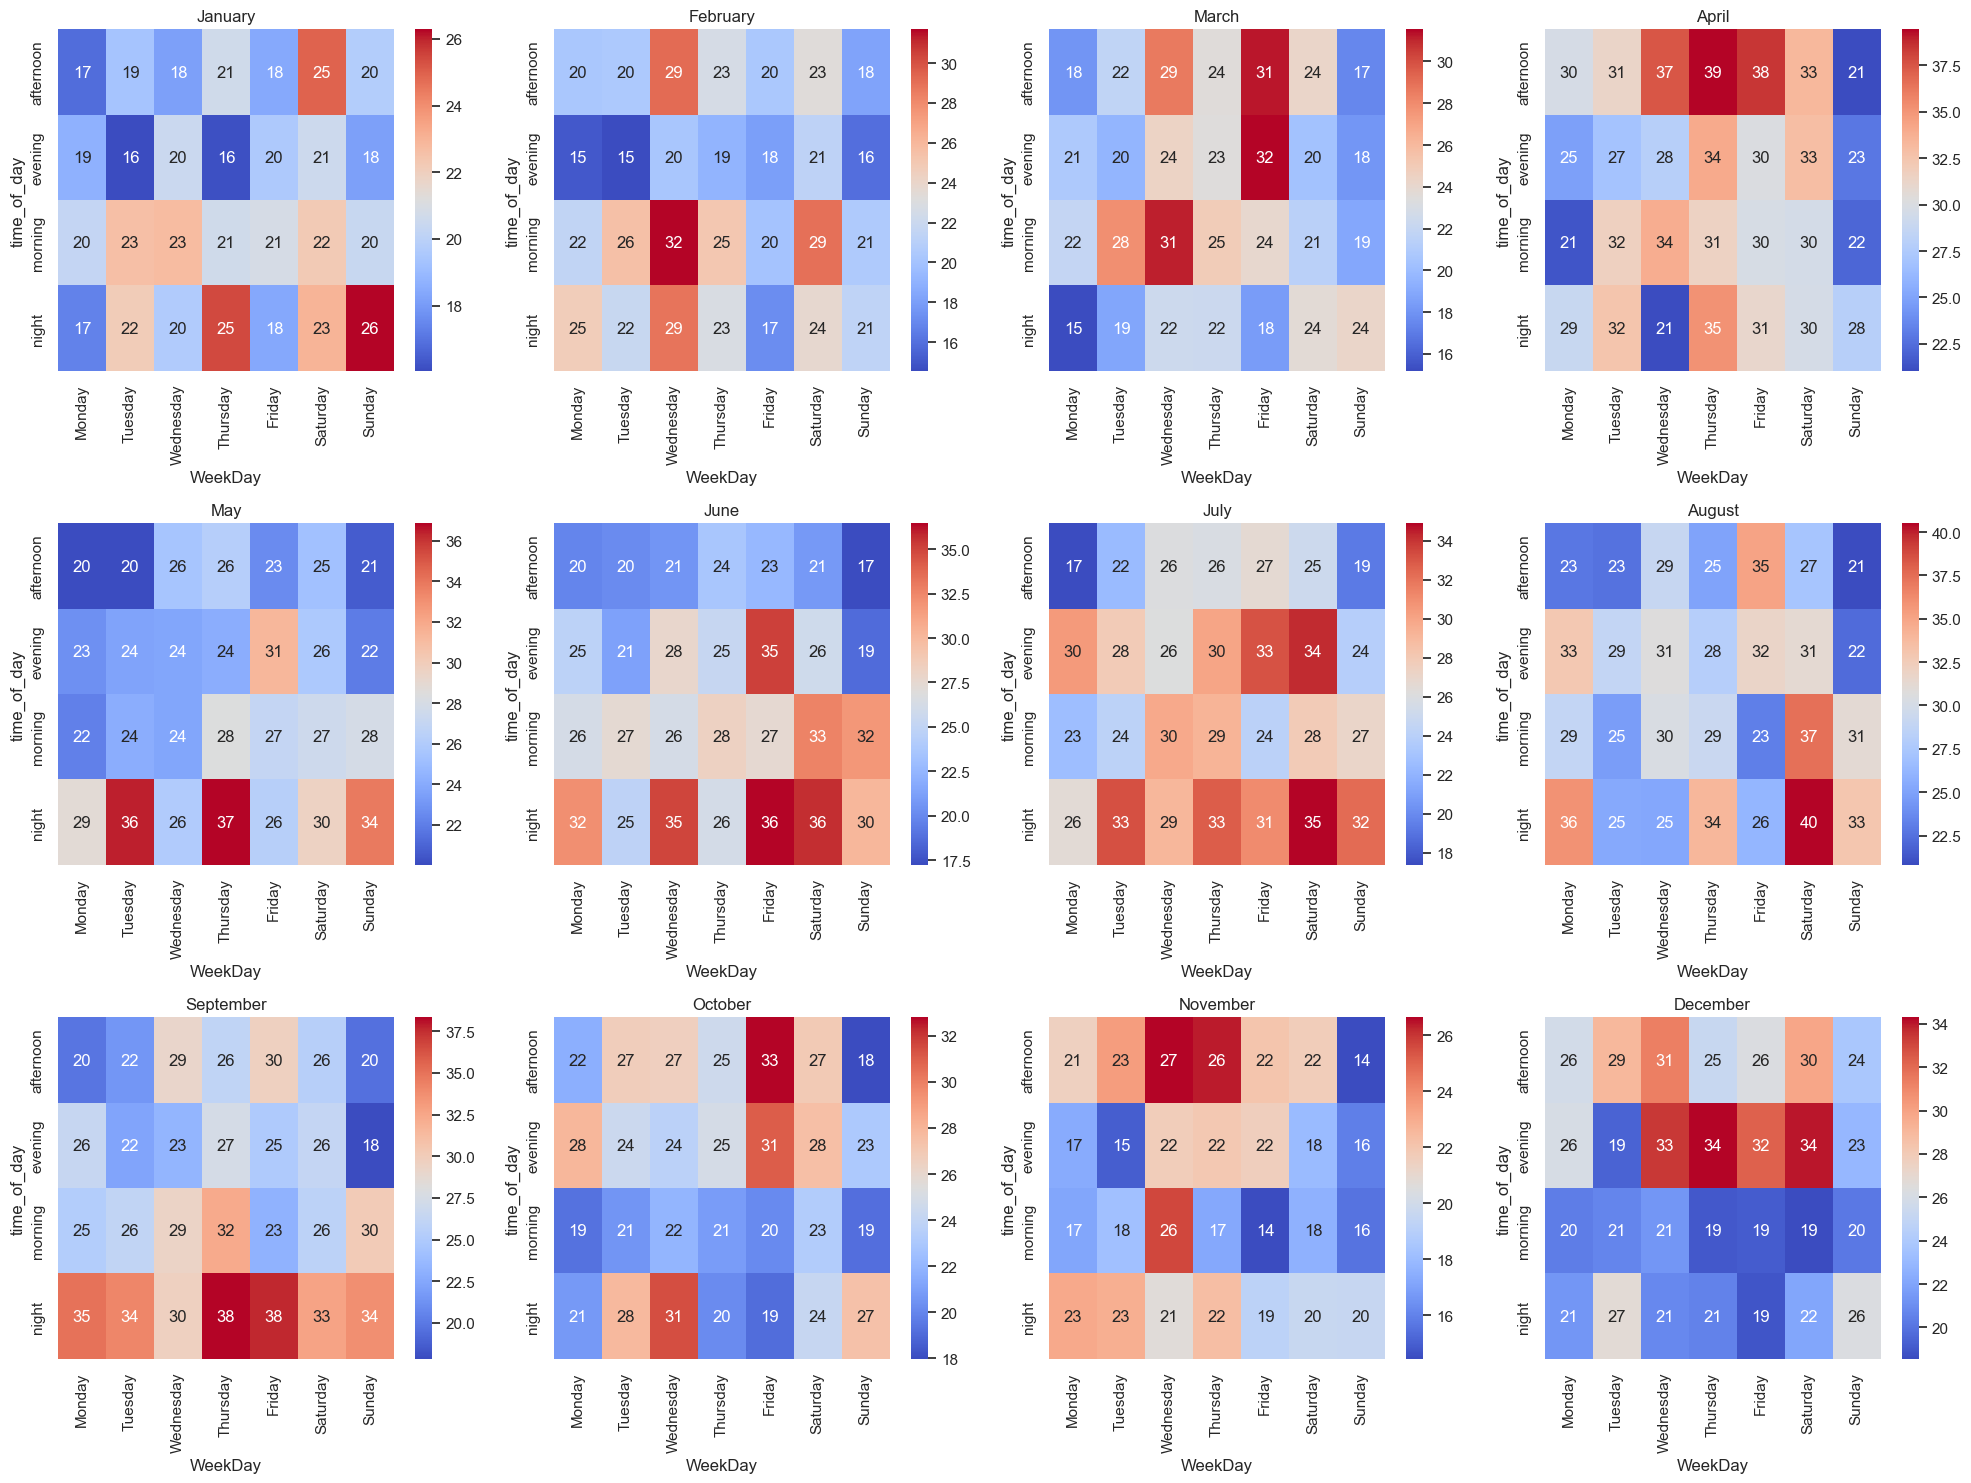

In [30]:
# For each mont let's understand the average of wait time by time of the day and week day.
df_month_time_day = df_jfk.groupby(['Month', 'time_of_day', 'WeekDay'])['AverageWait'].mean()
df_month_time_day = df_month_time_day.reset_index()
df_month_time_day = df_month_time_day.pivot(index=['Month', 'time_of_day'], columns='WeekDay', values='AverageWait')
df_month_time_day = df_month_time_day[[day for day in week_day_order.keys()]]
df_month_time_day = df_month_time_day.loc[[month for month in month_order.keys()]]


# Sublot for each month
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, month in enumerate(month_order.keys()):
    sns.heatmap(df_month_time_day.loc[month], annot=True, fmt=".0f", cmap='coolwarm', ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'{month}')
plt.tight_layout()
plt.show()


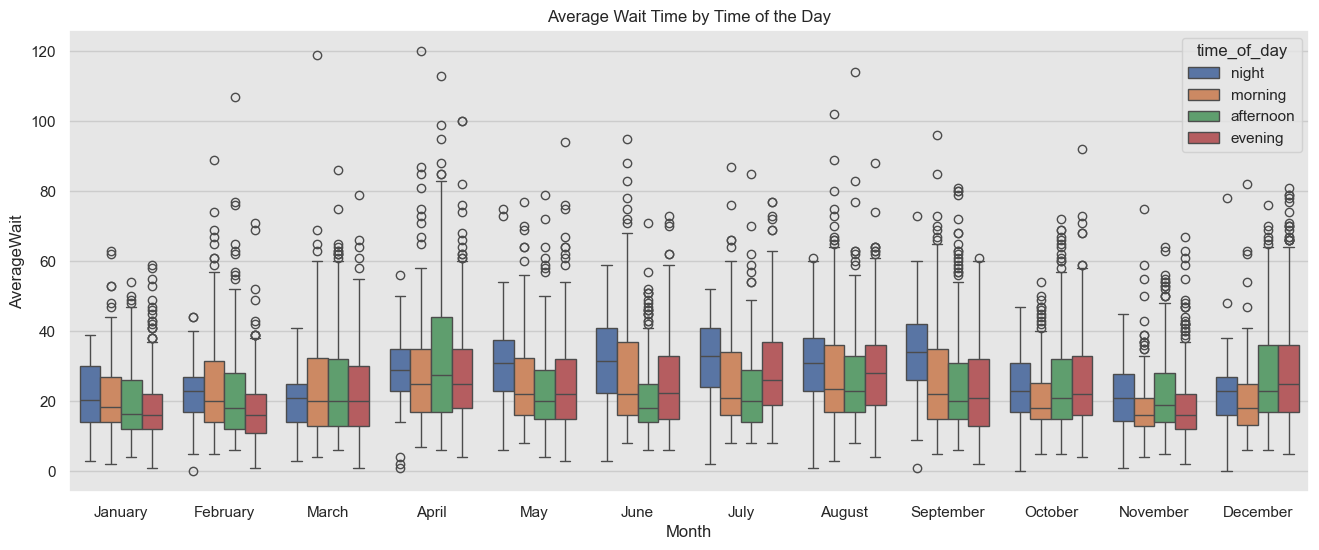

In [31]:
# boxplot of the average wait time by time of the day and month
plt.figure(figsize=(16, 6))
sns.boxplot(x='Month', y='AverageWait',hue='time_of_day', data=df_jfk)
plt.title('Average Wait Time by Time of the Day')
plt.show()


### Understanding the how the arrival rate depends on the time of day.
- We will treat the historical data as "realizations" of the unknown poisson RV's for each hour of the day

In [32]:
# filter data for specific month and time of the day

def filter_data(df, month=None, time_of_day=None):
    """
    Filter the data based on the month and time of the day.
    
    Parameters:
        df (DataFrame): The DataFrame to be filtered.
        month (str): The month to filter the data.
        time_of_day (str): The time of the day to filter the data.
    
    Returns:
        DataFrame: The filtered DataFrame.
    """
    if month is not None:
        df = df[df['Month'] == month]
    if time_of_day is not None:
        df = df[df['time_of_day'] == time_of_day]
    else:
        df = df
    return df


In [33]:
df_jfk_filtered = filter_data(df_jfk, month=None, time_of_day=None)

In [34]:
hours = df_jfk_filtered["time_of_day"].drop_duplicates().tolist()
hour_dict = {}
for h in hours:
    hour_dict[h] = df_jfk_filtered[df_jfk_filtered["time_of_day"] == h].reset_index(drop=True)["TotalPassengerCount"].tolist()

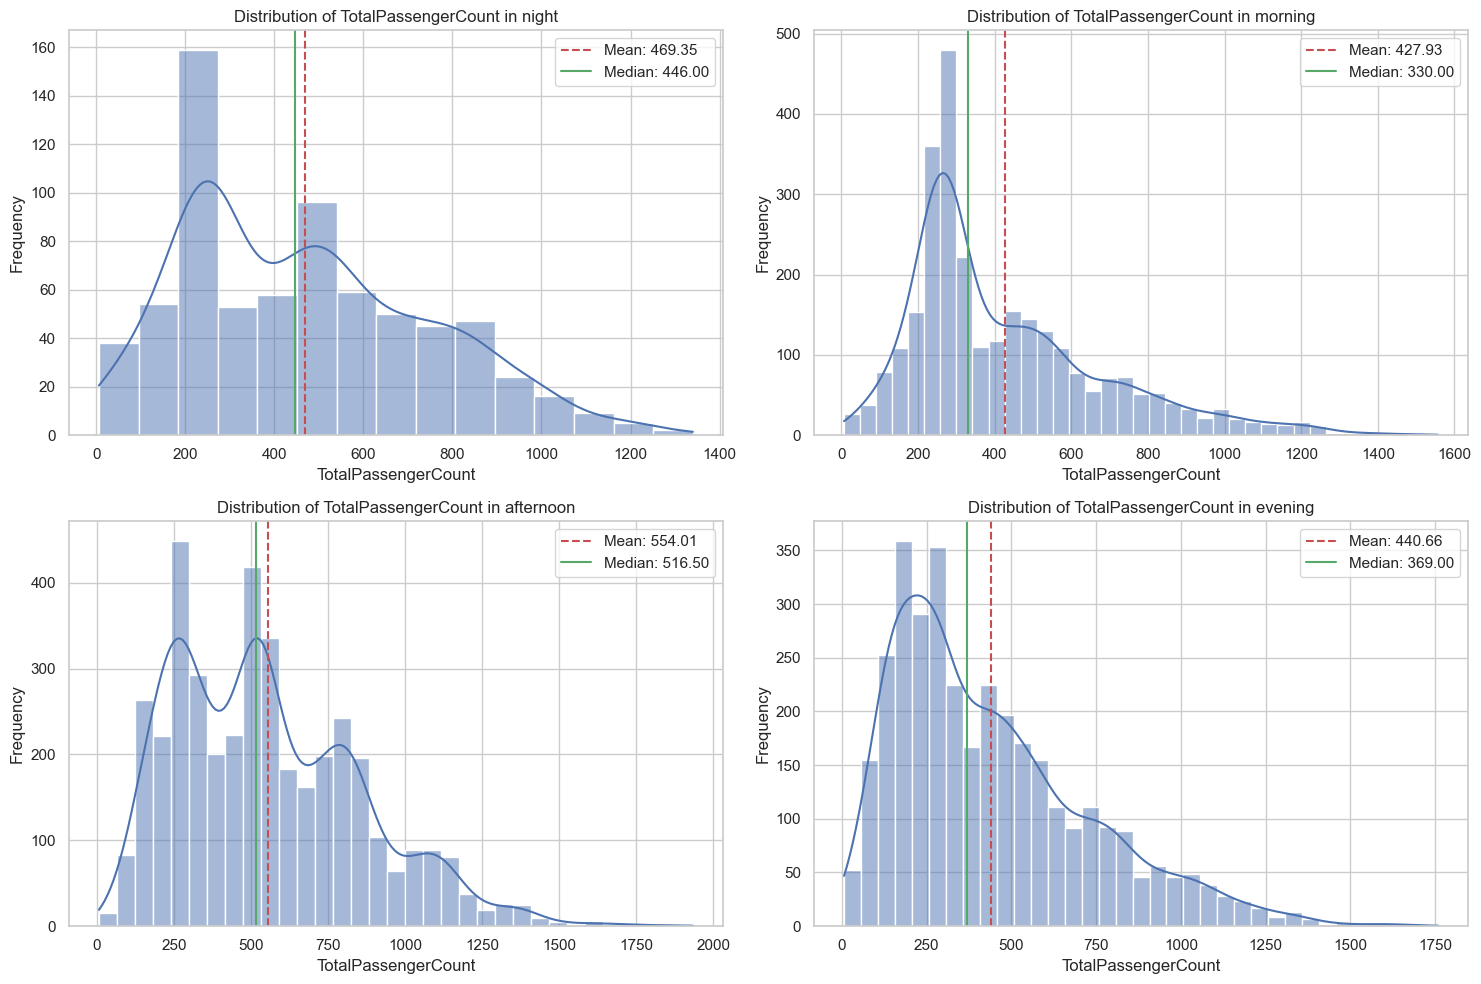

In [35]:
sns.set(style="whitegrid")  # Set a Seaborn style for cleaner visuals

# Create histograms for each hour in a subplot for each h in hours
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, h in enumerate(hours):
    sns.histplot(hour_dict[h], kde=True, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f"Distribution of TotalPassengerCount in {h}")
    axs[i//2, i%2].set_xlabel("TotalPassengerCount")
    axs[i//2, i%2].set_ylabel("Frequency")
    # Mean and the median of the distribution
    axs[i//2, i%2].axvline(np.mean(hour_dict[h]), color='r', linestyle='--', label=f'Mean: {np.mean(hour_dict[h]):.2f}')
    axs[i//2, i%2].axvline(np.median(hour_dict[h]), color='g', linestyle='-', label=f'Median: {np.median(hour_dict[h]):.2f}')
    axs[i//2, i%2].legend()
    
plt.tight_layout()
plt.show()

In [36]:
# Function to calculate the mean and the median from the distribution of each time of the day
def calculate_mean_median(df, time_of_day):
    """
    Calculate the mean and the median from the distribution of each time of the day.
    
    Parameters:
        df (DataFrame): The DataFrame to be filtered.
        time_of_day (str): The time of the day to filter the data.
    
    Returns:
        float: The mean of the distribution.
        float: The median of the distribution.
    """
    df_filtered = filter_data(df, time_of_day=time_of_day)
    return df_filtered["TotalPassengerCount"].mean(), df_filtered["TotalPassengerCount"].median()

# Calculate the mean and the median for each time of the day
mean_median = {}
for h in hours:
    mean_median[h] = calculate_mean_median(df_jfk, h)

# Create a DataFrame from the dictionary
mean_median_df = pd.DataFrame(mean_median, index=['Mean', 'Median'])
mean_median_df


,night,morning,afternoon,evening
Mean,469.352448,427.926486,554.010128,440.656786
Median,446.000000,330.000000,516.500000,369.000000


## Forcast the number of passengers arriving

In [37]:
# Calculate the service rate for each month and time of the day
service_rate_values = service_rate(df_jfk)
service_rate_values

c:\Users\simon\OneDrive - andrew.cmu.edu\Classes\Fall_2024\Decision Analytics\FinalProject\cbp_scheduling\utils.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ServiceRate'] = df['TotalPassengerCount'] / df['BoothsUsed']


43.04479791616462